<a href="https://colab.research.google.com/github/callezenwaka/machine-learning/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [99]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pandas.plotting import scatter_matrix

In [100]:
# define seed
SEED = 1234

In [101]:
# set seed value for reproducibility
np.random.seed(SEED)
random.seed(SEED)

# Load Data

In [102]:
# read from csv to pandas dataframe
url =  "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load data
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [103]:
# define X and y
X = df[['leukocyte_count', 'blood_pressure']].values
y = df['tumor_class'].values

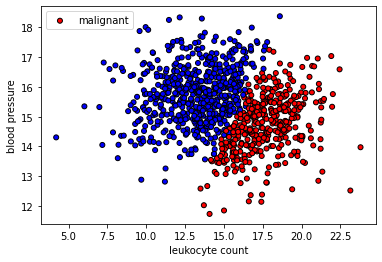

In [104]:
# plot data
colors = {'benign': 'red', 'malignant': 'blue'}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors='k')
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(['malignant', 'benign'], loc="upper left")
plt.show()

# Split Dataset

In [105]:
# import dependencies
import collections
from sklearn.model_selection import  train_test_split

In [106]:
# define split sizes
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [107]:
# define split function
def train_val_test_split(X, y, train_size):
  """Split dataset into data splits."""
  X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [108]:
# create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


In [109]:
# overall class distribution
class_counts = dict(collections.Counter(y))
print(f"Classes: {class_counts}")
print(f"m:b = {class_counts['malignant']/class_counts['benign']:.2f}")

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [110]:
# per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
print(f"train m:b = {train_class_counts['malignant']/train_class_counts['benign']:.2f}")
print(f"val m:b = {val_class_counts['malignant']/val_class_counts['benign']:.2f}")
print(f"test m:b = {test_class_counts['malignant']/test_class_counts['benign']:.2f}")

train m:b = 1.57
val m:b = 1.54
test m:b = 1.59


# Label Encoding

In [111]:
# import dependencies
import itertools

In [112]:
# define LabelEncoder function
class LabelEncoder(object):
  """Label encoder for tag labels."""

  def __init__(self, class_to_index={}):
    """Initialize label encoder."""
    self.class_to_index = class_to_index
    self.index_to_class = {v: k for k, v in self.class_to_index.items()}
    self.classes = list(self.class_to_index.keys())

  def __len__(self):
    return len(self.class_to_index)

  def __str__(self):
    return f"<LabelEncoder(num_classes={len(self)})>"

  def fit(self, y):
    classes = np.unique(y)
    for i, class_ in enumerate(classes):
      self.class_to_index[class_] = i
    self.index_to_class = {v: k for k, v in self.class_to_index.items()}
    self.classes = list(self.class_to_index.keys())
    return self

  def encode(self, y):
    encoded = np.zeros((len(y)), dtype=int)
    for i, item in enumerate(y):
      encoded[i] = self.class_to_index[item]
    return encoded

  def decode(self, y):
    classes = []
    for i, item in enumerate(y):
      classes.append(self.index_to_class[item])
    return classes
  
  def save(self, fp):
    with open(fp, 'w') as fp:
      contents = {'class_to_index': self.class_to_index}
      json.dump(contents, fp, indent=4, sort_keys=False)

  @classmethod
  def load(cls, fp):
    with open(fp, 'r') as fp:
      kwargs = json.load(fp=fp)
    return

In [113]:
# fit
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'benign': 0, 'malignant': 1}

In [114]:
# encoder
print(f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print(f"y_train[0]: {y_train[0]}")
print(f"decoded: {label_encoder.decode([y_train[0]])}")

y_train[0]: malignant
y_train[0]: 1
decoded: ['malignant']


In [115]:
# class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print(f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


# Standardize Data

In [116]:
# using StandardScaler
from sklearn.preprocessing import StandardScaler

In [117]:
# standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [118]:
# apply scaler on training & test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [119]:
# check: (means should be ~0 and std be ~1)
print(f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print(f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


# Logistic Regression with Numpy

# Initializwe weights

In [120]:
# initialize hyperparameters
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
NUM_CLASSES = len(label_encoder.classes) # y has 2 possibilities (benign or malignant)
LEARNING_RATE = 1e-1
NUM_EPOCHS = 50

In [121]:
# initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print(f"W: {W.shape}")
print(f"b: {b.shape}")

W: (2, 2)
b: (1, 2)


# Model

In [122]:
# forward pass [Nx2] · [2x2] + [1,2] = [Nx2]
logits = np.dot(X_train, W) + b
print(f"logits: {logits.shape}")
print(f"sample: {logits[0]}")

logits: (700, 2)
sample: [-0.0069945   0.00647147]


In [123]:
# normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print(f"y_hat: {y_hat.shape}")
print(f"sample: {y_hat[0]}")

y_hat: (700, 2)
sample: [0.49663356 0.50336644]


# Loss

In [124]:
# loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)) , y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print(f"loss: {loss:.2f}")

loss: 0.70


# Gradient

In [125]:
# backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)

# Update Weights

In [126]:
# update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db

# Training

In [127]:
# initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))

In [128]:
# training loop
for epoch_num in range(NUM_EPOCHS):

  # forward pass [Nx2] · [2x2] = [Nx2]
  logits = np.dot(X_train, W) + b

  # normalization via softmax to obtain class probabilities
  exp_logits = np.exp(logits)
  y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

  # loss
  correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
  loss = np.sum(correct_class_logprobs) / len(y_train)

  # show training progress
  if epoch_num%10 == 0:
    # accuracy
    y_pred = np.argmax(logits, axis=1)
    accuracy = np.mean(np.equal(y_train, y_pred))
    print(f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

  # backpropagation
  dscores = y_hat
  dscores[range(len(y_hat)), y_train] -= 1
  dscores /= len(y_train)
  dW = np.dot(X_train.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  # update weights
  W += -LEARNING_RATE * dW
  b += -LEARNING_RATE * db

Epoch: 0, loss: 0.684, accuracy: 0.897
Epoch: 10, loss: 0.446, accuracy: 0.970
Epoch: 20, loss: 0.349, accuracy: 0.973
Epoch: 30, loss: 0.297, accuracy: 0.973
Epoch: 40, loss: 0.263, accuracy: 0.973


# Evaluation

In [129]:
# define LogisticRegressionFromScratch class
class LogisticRegressionFromScratch():
  """Define LogisticRegressionFromScratch class."""
  
  def predict(self, x):
    """Define predict function."""
    logits = np.dot(x, W) + b
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return y_hat

In [130]:
# model evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)

In [131]:
# training & test accuracy
train_acc = np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print(f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.97, test acc: 0.97


In [132]:
# # define plot function
# def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
#   """Plot the multiclass decision boundary for a model that accepts 2D inputs.
#   Credit: https://cs231n.github.io/neural-networks-case-study/

#   Arguments:
#       model {function} -- trained model with function model.predict(x_in).
#       X {numpy.ndarray} -- 2D inputs with shape (N, 2).
#       y {numpy.ndarray} -- 1D outputs with shape (N,).
#   """

#   # axis boundaries
#   x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
#   y_min, y_max = X[:, 1].min() - 0.1, X[: 1].max() + 0.1
#   xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
#                        np.linspace(y_min, y_max, 101))

#   # create predictions
#   x_in = np.c_[(xx.ravel(), yy.ravel())]
#   y_pred = model.predict(x_in)
#   y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

#   # plot decision boundary
#   plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
#   plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
#   plt.xlim(xx.min(), xx.max())
#   plt.ylim(yy.min(), yy.max())

#   # plot
#   if savefig_fp:
#     plt.savefig(savefig_fp, format="png")

In [133]:
# # visualize the decision boundary
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.title("Train")
# plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
# plt.subplot(1,2,2)
# plt.title("Test")
# plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
# plt.show()

In [134]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format='png')

In [135]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

TypeError: ignored

<Figure size 864x360 with 0 Axes>